# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

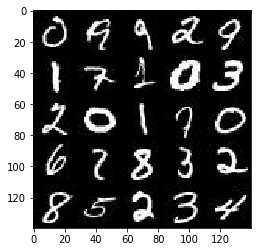

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

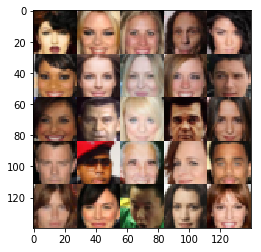

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="Real_Input")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='Z_Input')
    learn_rate = tf.placeholder(tf.float32, [], name='Learning_Rate')

    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2 
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3 - 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64 - 28x28x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128 - 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 - 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    #if is_train == True:
    #    reuse = False
    #else:
    #    reuse = True
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now 28x28x3
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _ , image_width, image_height, image_channels = data_shape
    image_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(image_input, z_input, len(data_image_mode))
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        Batch = 0
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={image_input: batch_images, z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, lr:learning_rate})
                Batch +=1
                if Batch % 10 == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, image_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count), " Batch: {} - ".format(Batch),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if Batch % 100 == 0:
                    show_generator_output(sess, 25, z_input, image_channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2...  Batch: 10 -  Discriminator Loss: 0.0212... Generator Loss: 6.0536
Epoch 1/2...  Batch: 20 -  Discriminator Loss: 1.9248... Generator Loss: 0.6489
Epoch 1/2...  Batch: 30 -  Discriminator Loss: 2.5391... Generator Loss: 0.2202
Epoch 1/2...  Batch: 40 -  Discriminator Loss: 2.0161... Generator Loss: 0.2867
Epoch 1/2...  Batch: 50 -  Discriminator Loss: 2.1286... Generator Loss: 0.2945
Epoch 1/2...  Batch: 60 -  Discriminator Loss: 1.9610... Generator Loss: 0.3752
Epoch 1/2...  Batch: 70 -  Discriminator Loss: 1.9942... Generator Loss: 0.2817
Epoch 1/2...  Batch: 80 -  Discriminator Loss: 1.9423... Generator Loss: 0.3289
Epoch 1/2...  Batch: 90 -  Discriminator Loss: 1.9319... Generator Loss: 0.2966
Epoch 1/2...  Batch: 100 -  Discriminator Loss: 1.6126... Generator Loss: 0.5413


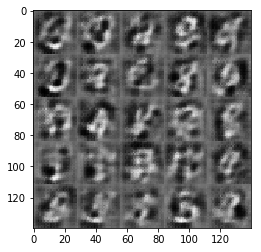

Epoch 1/2...  Batch: 110 -  Discriminator Loss: 1.7722... Generator Loss: 0.2936
Epoch 1/2...  Batch: 120 -  Discriminator Loss: 1.9749... Generator Loss: 0.3096
Epoch 1/2...  Batch: 130 -  Discriminator Loss: 2.1109... Generator Loss: 0.2726
Epoch 1/2...  Batch: 140 -  Discriminator Loss: 2.0083... Generator Loss: 0.2471
Epoch 1/2...  Batch: 150 -  Discriminator Loss: 1.7828... Generator Loss: 0.3177
Epoch 1/2...  Batch: 160 -  Discriminator Loss: 1.7614... Generator Loss: 0.5992
Epoch 1/2...  Batch: 170 -  Discriminator Loss: 1.2629... Generator Loss: 0.8297
Epoch 1/2...  Batch: 180 -  Discriminator Loss: 1.7170... Generator Loss: 1.5090
Epoch 1/2...  Batch: 190 -  Discriminator Loss: 1.3626... Generator Loss: 1.2400
Epoch 1/2...  Batch: 200 -  Discriminator Loss: 1.3871... Generator Loss: 0.7340


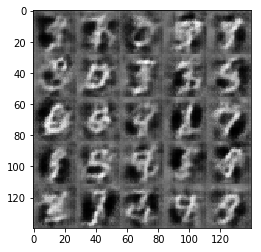

Epoch 1/2...  Batch: 210 -  Discriminator Loss: 1.3460... Generator Loss: 0.7325
Epoch 1/2...  Batch: 220 -  Discriminator Loss: 1.6191... Generator Loss: 1.1951
Epoch 1/2...  Batch: 230 -  Discriminator Loss: 1.7077... Generator Loss: 1.3517
Epoch 1/2...  Batch: 240 -  Discriminator Loss: 1.6171... Generator Loss: 1.0938
Epoch 1/2...  Batch: 250 -  Discriminator Loss: 1.4091... Generator Loss: 1.1029
Epoch 1/2...  Batch: 260 -  Discriminator Loss: 1.8892... Generator Loss: 1.6376
Epoch 1/2...  Batch: 270 -  Discriminator Loss: 1.9338... Generator Loss: 1.7044
Epoch 1/2...  Batch: 280 -  Discriminator Loss: 1.7168... Generator Loss: 1.3160
Epoch 1/2...  Batch: 290 -  Discriminator Loss: 1.3863... Generator Loss: 0.6864
Epoch 1/2...  Batch: 300 -  Discriminator Loss: 1.8654... Generator Loss: 0.2189


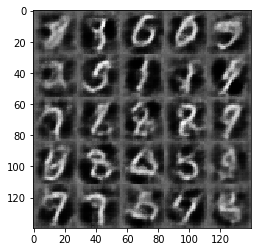

Epoch 1/2...  Batch: 310 -  Discriminator Loss: 1.3419... Generator Loss: 1.0840
Epoch 1/2...  Batch: 320 -  Discriminator Loss: 1.9010... Generator Loss: 1.5848
Epoch 1/2...  Batch: 330 -  Discriminator Loss: 1.5663... Generator Loss: 0.3655
Epoch 1/2...  Batch: 340 -  Discriminator Loss: 1.4999... Generator Loss: 0.7794
Epoch 1/2...  Batch: 350 -  Discriminator Loss: 1.3951... Generator Loss: 1.0828
Epoch 1/2...  Batch: 360 -  Discriminator Loss: 2.4473... Generator Loss: 1.3696
Epoch 1/2...  Batch: 370 -  Discriminator Loss: 1.4783... Generator Loss: 0.5213
Epoch 1/2...  Batch: 380 -  Discriminator Loss: 1.7229... Generator Loss: 1.3413
Epoch 1/2...  Batch: 390 -  Discriminator Loss: 1.5684... Generator Loss: 1.1749
Epoch 1/2...  Batch: 400 -  Discriminator Loss: 1.5298... Generator Loss: 1.5064


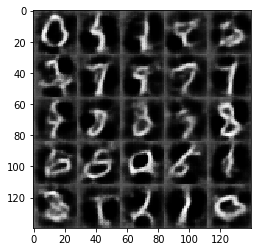

Epoch 1/2...  Batch: 410 -  Discriminator Loss: 1.3610... Generator Loss: 0.5221
Epoch 1/2...  Batch: 420 -  Discriminator Loss: 1.6106... Generator Loss: 1.1548
Epoch 1/2...  Batch: 430 -  Discriminator Loss: 1.4203... Generator Loss: 0.5450
Epoch 1/2...  Batch: 440 -  Discriminator Loss: 1.6001... Generator Loss: 0.3241
Epoch 1/2...  Batch: 450 -  Discriminator Loss: 1.4408... Generator Loss: 0.7993
Epoch 1/2...  Batch: 460 -  Discriminator Loss: 1.3903... Generator Loss: 0.8166
Epoch 2/2...  Batch: 470 -  Discriminator Loss: 1.3617... Generator Loss: 0.5032
Epoch 2/2...  Batch: 480 -  Discriminator Loss: 1.4036... Generator Loss: 0.7668
Epoch 2/2...  Batch: 490 -  Discriminator Loss: 1.5824... Generator Loss: 1.3171
Epoch 2/2...  Batch: 500 -  Discriminator Loss: 1.5987... Generator Loss: 1.6800


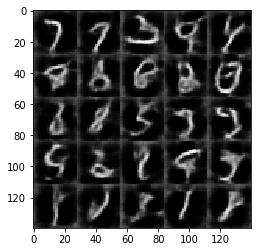

Epoch 2/2...  Batch: 510 -  Discriminator Loss: 1.4126... Generator Loss: 0.4232
Epoch 2/2...  Batch: 520 -  Discriminator Loss: 1.3130... Generator Loss: 0.5468
Epoch 2/2...  Batch: 530 -  Discriminator Loss: 1.5052... Generator Loss: 1.6898
Epoch 2/2...  Batch: 540 -  Discriminator Loss: 1.3480... Generator Loss: 0.5460
Epoch 2/2...  Batch: 550 -  Discriminator Loss: 2.2783... Generator Loss: 2.2299
Epoch 2/2...  Batch: 560 -  Discriminator Loss: 1.4219... Generator Loss: 0.5831
Epoch 2/2...  Batch: 570 -  Discriminator Loss: 1.2555... Generator Loss: 0.7521
Epoch 2/2...  Batch: 580 -  Discriminator Loss: 0.9825... Generator Loss: 0.9086
Epoch 2/2...  Batch: 590 -  Discriminator Loss: 1.5466... Generator Loss: 0.4325
Epoch 2/2...  Batch: 600 -  Discriminator Loss: 1.6812... Generator Loss: 0.3034


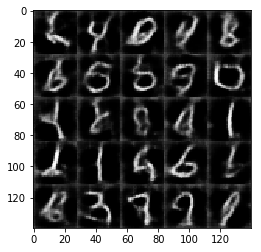

Epoch 2/2...  Batch: 610 -  Discriminator Loss: 1.3223... Generator Loss: 0.7083
Epoch 2/2...  Batch: 620 -  Discriminator Loss: 2.1706... Generator Loss: 1.5931
Epoch 2/2...  Batch: 630 -  Discriminator Loss: 1.4697... Generator Loss: 0.4111
Epoch 2/2...  Batch: 640 -  Discriminator Loss: 1.6445... Generator Loss: 0.3063
Epoch 2/2...  Batch: 650 -  Discriminator Loss: 1.5271... Generator Loss: 0.3298
Epoch 2/2...  Batch: 660 -  Discriminator Loss: 2.9200... Generator Loss: 0.0795
Epoch 2/2...  Batch: 670 -  Discriminator Loss: 1.3196... Generator Loss: 0.7762
Epoch 2/2...  Batch: 680 -  Discriminator Loss: 1.7911... Generator Loss: 0.2385
Epoch 2/2...  Batch: 690 -  Discriminator Loss: 1.3978... Generator Loss: 0.4627
Epoch 2/2...  Batch: 700 -  Discriminator Loss: 1.2713... Generator Loss: 1.3131


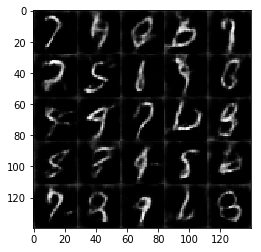

Epoch 2/2...  Batch: 710 -  Discriminator Loss: 1.4738... Generator Loss: 1.2373
Epoch 2/2...  Batch: 720 -  Discriminator Loss: 1.3219... Generator Loss: 0.9679
Epoch 2/2...  Batch: 730 -  Discriminator Loss: 1.1675... Generator Loss: 0.7383
Epoch 2/2...  Batch: 740 -  Discriminator Loss: 1.0020... Generator Loss: 0.9268
Epoch 2/2...  Batch: 750 -  Discriminator Loss: 2.4186... Generator Loss: 3.9456
Epoch 2/2...  Batch: 760 -  Discriminator Loss: 1.4581... Generator Loss: 0.3618
Epoch 2/2...  Batch: 770 -  Discriminator Loss: 1.1904... Generator Loss: 0.5305
Epoch 2/2...  Batch: 780 -  Discriminator Loss: 1.6557... Generator Loss: 1.6221
Epoch 2/2...  Batch: 790 -  Discriminator Loss: 1.2290... Generator Loss: 0.6128
Epoch 2/2...  Batch: 800 -  Discriminator Loss: 1.7266... Generator Loss: 0.2821


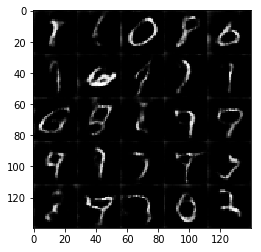

Epoch 2/2...  Batch: 810 -  Discriminator Loss: 1.2641... Generator Loss: 0.4326
Epoch 2/2...  Batch: 820 -  Discriminator Loss: 1.3146... Generator Loss: 0.5584
Epoch 2/2...  Batch: 830 -  Discriminator Loss: 1.4741... Generator Loss: 0.4801
Epoch 2/2...  Batch: 840 -  Discriminator Loss: 1.2940... Generator Loss: 1.4476
Epoch 2/2...  Batch: 850 -  Discriminator Loss: 1.0230... Generator Loss: 0.7712
Epoch 2/2...  Batch: 860 -  Discriminator Loss: 1.7546... Generator Loss: 0.2486
Epoch 2/2...  Batch: 870 -  Discriminator Loss: 1.6007... Generator Loss: 0.3636
Epoch 2/2...  Batch: 880 -  Discriminator Loss: 1.3233... Generator Loss: 0.4483
Epoch 2/2...  Batch: 890 -  Discriminator Loss: 3.1024... Generator Loss: 0.1198
Epoch 2/2...  Batch: 900 -  Discriminator Loss: 0.9921... Generator Loss: 0.8058


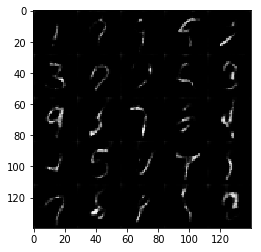

Epoch 2/2...  Batch: 910 -  Discriminator Loss: 1.2457... Generator Loss: 0.7255
Epoch 2/2...  Batch: 920 -  Discriminator Loss: 0.9335... Generator Loss: 1.1737
Epoch 2/2...  Batch: 930 -  Discriminator Loss: 1.0943... Generator Loss: 1.3682


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

##### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10...  Batch: 10 -  Discriminator Loss: 5.8592... Generator Loss: 0.0628
Epoch 1/10...  Batch: 20 -  Discriminator Loss: 3.3635... Generator Loss: 0.1407
Epoch 1/10...  Batch: 30 -  Discriminator Loss: 2.9526... Generator Loss: 0.1101
Epoch 1/10...  Batch: 40 -  Discriminator Loss: 1.5559... Generator Loss: 0.9424
Epoch 1/10...  Batch: 50 -  Discriminator Loss: 1.9257... Generator Loss: 0.4286
Epoch 1/10...  Batch: 60 -  Discriminator Loss: 1.9680... Generator Loss: 0.4107
Epoch 1/10...  Batch: 70 -  Discriminator Loss: 1.9738... Generator Loss: 0.5492
Epoch 1/10...  Batch: 80 -  Discriminator Loss: 1.8312... Generator Loss: 0.6211
Epoch 1/10...  Batch: 90 -  Discriminator Loss: 1.4700... Generator Loss: 1.0152
Epoch 1/10...  Batch: 100 -  Discriminator Loss: 1.8072... Generator Loss: 0.4433


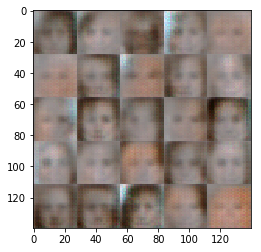

Epoch 1/10...  Batch: 110 -  Discriminator Loss: 1.3171... Generator Loss: 0.8822
Epoch 1/10...  Batch: 120 -  Discriminator Loss: 2.4130... Generator Loss: 0.2447
Epoch 1/10...  Batch: 130 -  Discriminator Loss: 1.7746... Generator Loss: 0.5331
Epoch 1/10...  Batch: 140 -  Discriminator Loss: 1.6623... Generator Loss: 0.5476
Epoch 1/10...  Batch: 150 -  Discriminator Loss: 1.6036... Generator Loss: 0.7059
Epoch 1/10...  Batch: 160 -  Discriminator Loss: 1.6608... Generator Loss: 0.4645
Epoch 1/10...  Batch: 170 -  Discriminator Loss: 1.4364... Generator Loss: 0.4226
Epoch 1/10...  Batch: 180 -  Discriminator Loss: 1.6499... Generator Loss: 0.9697
Epoch 1/10...  Batch: 190 -  Discriminator Loss: 1.5020... Generator Loss: 0.7444
Epoch 1/10...  Batch: 200 -  Discriminator Loss: 1.5242... Generator Loss: 0.7321


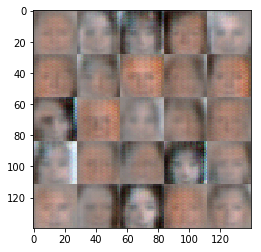

Epoch 1/10...  Batch: 210 -  Discriminator Loss: 1.3542... Generator Loss: 0.4553
Epoch 1/10...  Batch: 220 -  Discriminator Loss: 2.0426... Generator Loss: 0.1768
Epoch 1/10...  Batch: 230 -  Discriminator Loss: 1.8394... Generator Loss: 0.5621
Epoch 1/10...  Batch: 240 -  Discriminator Loss: 1.5567... Generator Loss: 0.6707
Epoch 1/10...  Batch: 250 -  Discriminator Loss: 1.4788... Generator Loss: 0.6814
Epoch 1/10...  Batch: 260 -  Discriminator Loss: 1.5743... Generator Loss: 0.4005
Epoch 1/10...  Batch: 270 -  Discriminator Loss: 1.4919... Generator Loss: 0.5709
Epoch 1/10...  Batch: 280 -  Discriminator Loss: 1.4654... Generator Loss: 0.5304
Epoch 1/10...  Batch: 290 -  Discriminator Loss: 1.5966... Generator Loss: 0.7585
Epoch 1/10...  Batch: 300 -  Discriminator Loss: 1.9349... Generator Loss: 0.2459


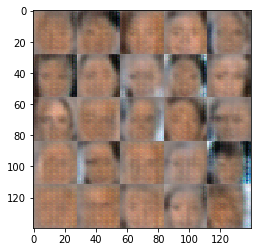

Epoch 1/10...  Batch: 310 -  Discriminator Loss: 1.8482... Generator Loss: 0.4279
Epoch 1/10...  Batch: 320 -  Discriminator Loss: 1.0387... Generator Loss: 1.4024
Epoch 1/10...  Batch: 330 -  Discriminator Loss: 1.6765... Generator Loss: 0.5099
Epoch 1/10...  Batch: 340 -  Discriminator Loss: 1.2318... Generator Loss: 0.5776
Epoch 1/10...  Batch: 350 -  Discriminator Loss: 1.5878... Generator Loss: 1.0438
Epoch 1/10...  Batch: 360 -  Discriminator Loss: 1.3483... Generator Loss: 1.4068
Epoch 1/10...  Batch: 370 -  Discriminator Loss: 1.2543... Generator Loss: 0.6392
Epoch 1/10...  Batch: 380 -  Discriminator Loss: 1.3522... Generator Loss: 2.1772
Epoch 1/10...  Batch: 390 -  Discriminator Loss: 1.7355... Generator Loss: 1.4795
Epoch 1/10...  Batch: 400 -  Discriminator Loss: 1.4953... Generator Loss: 0.7703


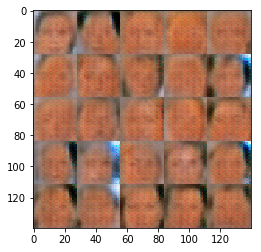

Epoch 1/10...  Batch: 410 -  Discriminator Loss: 1.1283... Generator Loss: 0.9223
Epoch 1/10...  Batch: 420 -  Discriminator Loss: 1.2027... Generator Loss: 0.6624
Epoch 1/10...  Batch: 430 -  Discriminator Loss: 0.7761... Generator Loss: 0.9061
Epoch 1/10...  Batch: 440 -  Discriminator Loss: 3.4408... Generator Loss: 2.5071
Epoch 1/10...  Batch: 450 -  Discriminator Loss: 1.5399... Generator Loss: 0.8680
Epoch 1/10...  Batch: 460 -  Discriminator Loss: 1.9501... Generator Loss: 0.3227
Epoch 1/10...  Batch: 470 -  Discriminator Loss: 1.5156... Generator Loss: 0.6442
Epoch 1/10...  Batch: 480 -  Discriminator Loss: 1.5256... Generator Loss: 0.5269
Epoch 1/10...  Batch: 490 -  Discriminator Loss: 1.5757... Generator Loss: 0.6571
Epoch 1/10...  Batch: 500 -  Discriminator Loss: 1.5809... Generator Loss: 0.7470


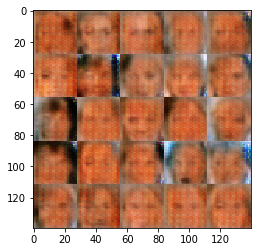

Epoch 1/10...  Batch: 510 -  Discriminator Loss: 1.6684... Generator Loss: 0.6543
Epoch 1/10...  Batch: 520 -  Discriminator Loss: 1.6152... Generator Loss: 0.6157
Epoch 1/10...  Batch: 530 -  Discriminator Loss: 1.7112... Generator Loss: 0.9296
Epoch 1/10...  Batch: 540 -  Discriminator Loss: 1.5249... Generator Loss: 0.6866
Epoch 1/10...  Batch: 550 -  Discriminator Loss: 1.6776... Generator Loss: 0.4853
Epoch 1/10...  Batch: 560 -  Discriminator Loss: 1.7030... Generator Loss: 0.9454
Epoch 1/10...  Batch: 570 -  Discriminator Loss: 1.8515... Generator Loss: 0.4556
Epoch 1/10...  Batch: 580 -  Discriminator Loss: 1.7090... Generator Loss: 0.5703
Epoch 1/10...  Batch: 590 -  Discriminator Loss: 1.7808... Generator Loss: 0.6704
Epoch 1/10...  Batch: 600 -  Discriminator Loss: 1.5709... Generator Loss: 0.7480


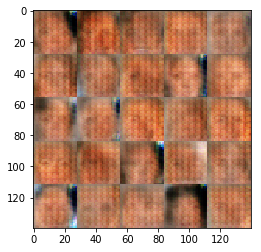

Epoch 1/10...  Batch: 610 -  Discriminator Loss: 1.9257... Generator Loss: 0.5690
Epoch 1/10...  Batch: 620 -  Discriminator Loss: 1.8304... Generator Loss: 0.7055
Epoch 1/10...  Batch: 630 -  Discriminator Loss: 1.5462... Generator Loss: 0.5158
Epoch 1/10...  Batch: 640 -  Discriminator Loss: 1.4721... Generator Loss: 0.7137
Epoch 1/10...  Batch: 650 -  Discriminator Loss: 1.5609... Generator Loss: 0.4627
Epoch 1/10...  Batch: 660 -  Discriminator Loss: 1.6342... Generator Loss: 0.5670
Epoch 1/10...  Batch: 670 -  Discriminator Loss: 1.7250... Generator Loss: 0.6916
Epoch 1/10...  Batch: 680 -  Discriminator Loss: 1.5477... Generator Loss: 0.7395
Epoch 1/10...  Batch: 690 -  Discriminator Loss: 1.5968... Generator Loss: 0.6282
Epoch 1/10...  Batch: 700 -  Discriminator Loss: 1.5249... Generator Loss: 0.6133


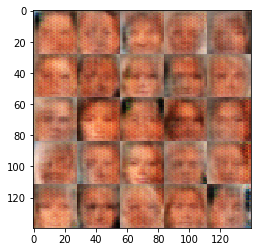

Epoch 1/10...  Batch: 710 -  Discriminator Loss: 1.5051... Generator Loss: 0.5432
Epoch 1/10...  Batch: 720 -  Discriminator Loss: 1.5887... Generator Loss: 0.5574
Epoch 1/10...  Batch: 730 -  Discriminator Loss: 1.5251... Generator Loss: 0.5520
Epoch 1/10...  Batch: 740 -  Discriminator Loss: 1.4065... Generator Loss: 0.6235
Epoch 1/10...  Batch: 750 -  Discriminator Loss: 1.4661... Generator Loss: 0.6655
Epoch 1/10...  Batch: 760 -  Discriminator Loss: 1.5378... Generator Loss: 0.7514
Epoch 1/10...  Batch: 770 -  Discriminator Loss: 1.6194... Generator Loss: 0.5909
Epoch 1/10...  Batch: 780 -  Discriminator Loss: 1.4259... Generator Loss: 0.7663
Epoch 1/10...  Batch: 790 -  Discriminator Loss: 1.6046... Generator Loss: 0.5436
Epoch 1/10...  Batch: 800 -  Discriminator Loss: 1.4699... Generator Loss: 0.6855


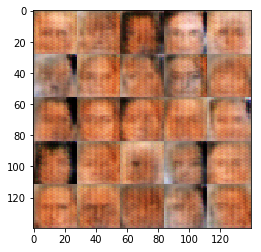

Epoch 1/10...  Batch: 810 -  Discriminator Loss: 1.5567... Generator Loss: 0.9231
Epoch 1/10...  Batch: 820 -  Discriminator Loss: 1.5662... Generator Loss: 0.5539
Epoch 1/10...  Batch: 830 -  Discriminator Loss: 1.5476... Generator Loss: 0.7461
Epoch 1/10...  Batch: 840 -  Discriminator Loss: 1.3915... Generator Loss: 0.8461
Epoch 1/10...  Batch: 850 -  Discriminator Loss: 1.5881... Generator Loss: 0.5682
Epoch 1/10...  Batch: 860 -  Discriminator Loss: 1.4422... Generator Loss: 0.9187
Epoch 1/10...  Batch: 870 -  Discriminator Loss: 1.4889... Generator Loss: 0.8242
Epoch 1/10...  Batch: 880 -  Discriminator Loss: 1.5271... Generator Loss: 0.7490
Epoch 1/10...  Batch: 890 -  Discriminator Loss: 1.4385... Generator Loss: 0.6370
Epoch 1/10...  Batch: 900 -  Discriminator Loss: 1.4611... Generator Loss: 0.6450


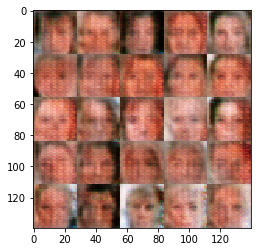

Epoch 1/10...  Batch: 910 -  Discriminator Loss: 1.5514... Generator Loss: 0.5400
Epoch 1/10...  Batch: 920 -  Discriminator Loss: 1.5590... Generator Loss: 0.5472
Epoch 1/10...  Batch: 930 -  Discriminator Loss: 1.6200... Generator Loss: 0.7279
Epoch 1/10...  Batch: 940 -  Discriminator Loss: 1.4740... Generator Loss: 0.6257
Epoch 1/10...  Batch: 950 -  Discriminator Loss: 1.4725... Generator Loss: 0.7464
Epoch 1/10...  Batch: 960 -  Discriminator Loss: 1.5144... Generator Loss: 0.6307
Epoch 1/10...  Batch: 970 -  Discriminator Loss: 1.7426... Generator Loss: 0.9587
Epoch 1/10...  Batch: 980 -  Discriminator Loss: 1.6255... Generator Loss: 0.7674
Epoch 1/10...  Batch: 990 -  Discriminator Loss: 1.4321... Generator Loss: 0.8272
Epoch 1/10...  Batch: 1000 -  Discriminator Loss: 1.5318... Generator Loss: 0.5638


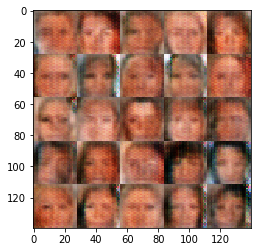

Epoch 1/10...  Batch: 1010 -  Discriminator Loss: 1.5067... Generator Loss: 0.8001
Epoch 1/10...  Batch: 1020 -  Discriminator Loss: 1.5398... Generator Loss: 0.7253
Epoch 1/10...  Batch: 1030 -  Discriminator Loss: 1.3988... Generator Loss: 0.6318
Epoch 1/10...  Batch: 1040 -  Discriminator Loss: 1.4699... Generator Loss: 0.8232
Epoch 1/10...  Batch: 1050 -  Discriminator Loss: 1.4397... Generator Loss: 0.6893
Epoch 1/10...  Batch: 1060 -  Discriminator Loss: 1.4652... Generator Loss: 0.8043
Epoch 1/10...  Batch: 1070 -  Discriminator Loss: 1.4520... Generator Loss: 0.7207
Epoch 1/10...  Batch: 1080 -  Discriminator Loss: 1.5171... Generator Loss: 0.6320
Epoch 1/10...  Batch: 1090 -  Discriminator Loss: 1.5953... Generator Loss: 0.4126
Epoch 1/10...  Batch: 1100 -  Discriminator Loss: 1.3537... Generator Loss: 0.9765


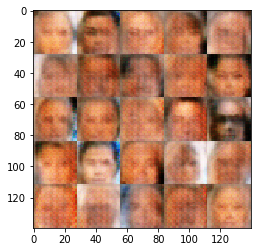

Epoch 1/10...  Batch: 1110 -  Discriminator Loss: 1.4456... Generator Loss: 0.8142
Epoch 1/10...  Batch: 1120 -  Discriminator Loss: 1.3102... Generator Loss: 0.6219
Epoch 1/10...  Batch: 1130 -  Discriminator Loss: 0.5108... Generator Loss: 1.1332
Epoch 1/10...  Batch: 1140 -  Discriminator Loss: 2.5156... Generator Loss: 0.2451
Epoch 1/10...  Batch: 1150 -  Discriminator Loss: 1.5383... Generator Loss: 0.7836
Epoch 1/10...  Batch: 1160 -  Discriminator Loss: 1.7794... Generator Loss: 1.0225
Epoch 1/10...  Batch: 1170 -  Discriminator Loss: 1.5589... Generator Loss: 0.5893
Epoch 1/10...  Batch: 1180 -  Discriminator Loss: 1.5712... Generator Loss: 0.5770
Epoch 1/10...  Batch: 1190 -  Discriminator Loss: 1.4899... Generator Loss: 0.7986
Epoch 1/10...  Batch: 1200 -  Discriminator Loss: 1.5680... Generator Loss: 0.7877


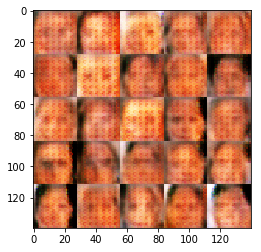

Epoch 1/10...  Batch: 1210 -  Discriminator Loss: 1.4451... Generator Loss: 0.7283
Epoch 1/10...  Batch: 1220 -  Discriminator Loss: 1.5226... Generator Loss: 0.6569
Epoch 1/10...  Batch: 1230 -  Discriminator Loss: 1.3932... Generator Loss: 0.6314
Epoch 1/10...  Batch: 1240 -  Discriminator Loss: 1.4718... Generator Loss: 0.7834
Epoch 1/10...  Batch: 1250 -  Discriminator Loss: 1.4987... Generator Loss: 0.7164
Epoch 1/10...  Batch: 1260 -  Discriminator Loss: 1.4858... Generator Loss: 0.5707
Epoch 1/10...  Batch: 1270 -  Discriminator Loss: 1.4546... Generator Loss: 0.6779
Epoch 1/10...  Batch: 1280 -  Discriminator Loss: 1.6540... Generator Loss: 0.6992
Epoch 1/10...  Batch: 1290 -  Discriminator Loss: 1.5963... Generator Loss: 0.6643
Epoch 1/10...  Batch: 1300 -  Discriminator Loss: 1.4927... Generator Loss: 0.6905


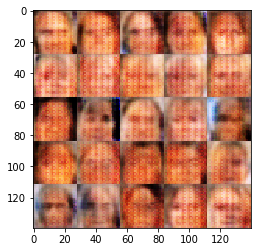

Epoch 1/10...  Batch: 1310 -  Discriminator Loss: 1.4323... Generator Loss: 0.6833
Epoch 1/10...  Batch: 1320 -  Discriminator Loss: 1.4944... Generator Loss: 0.7175
Epoch 1/10...  Batch: 1330 -  Discriminator Loss: 1.8963... Generator Loss: 0.4162
Epoch 1/10...  Batch: 1340 -  Discriminator Loss: 1.5993... Generator Loss: 0.5285
Epoch 1/10...  Batch: 1350 -  Discriminator Loss: 1.5498... Generator Loss: 0.6159
Epoch 1/10...  Batch: 1360 -  Discriminator Loss: 1.6197... Generator Loss: 0.6781
Epoch 1/10...  Batch: 1370 -  Discriminator Loss: 1.6144... Generator Loss: 0.5856
Epoch 1/10...  Batch: 1380 -  Discriminator Loss: 1.5422... Generator Loss: 0.7455
Epoch 1/10...  Batch: 1390 -  Discriminator Loss: 1.5378... Generator Loss: 0.6482
Epoch 1/10...  Batch: 1400 -  Discriminator Loss: 1.5244... Generator Loss: 0.6118


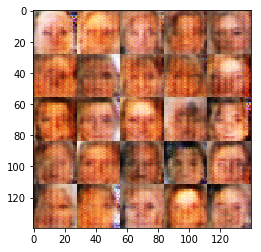

Epoch 1/10...  Batch: 1410 -  Discriminator Loss: 1.5331... Generator Loss: 0.6174
Epoch 1/10...  Batch: 1420 -  Discriminator Loss: 1.5421... Generator Loss: 0.6195
Epoch 1/10...  Batch: 1430 -  Discriminator Loss: 1.4953... Generator Loss: 0.6711
Epoch 1/10...  Batch: 1440 -  Discriminator Loss: 1.5063... Generator Loss: 0.6588
Epoch 1/10...  Batch: 1450 -  Discriminator Loss: 1.4673... Generator Loss: 0.5883
Epoch 1/10...  Batch: 1460 -  Discriminator Loss: 1.4284... Generator Loss: 0.7939
Epoch 1/10...  Batch: 1470 -  Discriminator Loss: 1.5086... Generator Loss: 0.6782
Epoch 1/10...  Batch: 1480 -  Discriminator Loss: 1.4844... Generator Loss: 0.7571
Epoch 1/10...  Batch: 1490 -  Discriminator Loss: 1.5882... Generator Loss: 0.7979
Epoch 1/10...  Batch: 1500 -  Discriminator Loss: 1.4359... Generator Loss: 0.5960


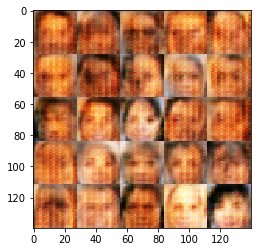

Epoch 1/10...  Batch: 1510 -  Discriminator Loss: 1.4407... Generator Loss: 0.7022
Epoch 1/10...  Batch: 1520 -  Discriminator Loss: 1.4887... Generator Loss: 0.7990
Epoch 1/10...  Batch: 1530 -  Discriminator Loss: 1.3853... Generator Loss: 0.7099
Epoch 1/10...  Batch: 1540 -  Discriminator Loss: 1.4285... Generator Loss: 0.7140
Epoch 1/10...  Batch: 1550 -  Discriminator Loss: 1.3673... Generator Loss: 0.8510
Epoch 1/10...  Batch: 1560 -  Discriminator Loss: 1.4891... Generator Loss: 0.5036
Epoch 1/10...  Batch: 1570 -  Discriminator Loss: 1.4582... Generator Loss: 0.7886
Epoch 1/10...  Batch: 1580 -  Discriminator Loss: 1.4428... Generator Loss: 0.8470
Epoch 2/10...  Batch: 1590 -  Discriminator Loss: 1.3971... Generator Loss: 0.7268
Epoch 2/10...  Batch: 1600 -  Discriminator Loss: 1.3002... Generator Loss: 0.8886


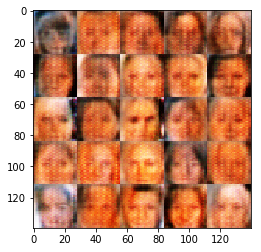

KeyboardInterrupt: 

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.